<a href="https://colab.research.google.com/github/asgutierrt/Ajuste-de-Curvas-Covid-19/blob/main/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicación de ajuste de curvas a modelos epidemiológicos en el contexto de la pandemia del coronavirus en Colombia
El presente notebook es del documento trabajo de semestre que posee el mismo nombre. Las ideas y procedimientos realizados están basados principalmente en:
* Álvarez, C.A. (Abril 25, 2020) Modelo matemático y computacional para predecir el comportamiento de la Covid-19. https://bit.ly/3vynEHo 

* Miramontes, O. (2020). Entendamos el COVID-19 en México. Universidad Nacional Autónoma de México. https://bit.ly/2R2N411  

El resto de las referencias, se encuentran en el documento pdf.

Importamos lo que necesitaremos a lo largo del proyecto para las diferentes implementaciones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import *
from scipy.integrate import odeint

!pip install lmfit
import lmfit

!pip install sodapy
from sodapy import Socrata

import datetime

     |████████████████████████████████| 307kB 6.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 256kB 12.5MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=455e7cc1d253377bec5f8e1e3c602cf87484936d8e210bde8897d595c3cb927b
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=b9d85be4353c01a09891f0aa176f935a12e3423ee6a346e416c275911f161b59
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval


# Datos para el modelo

## Datos del INS

Para nuestro proyecto hemos optado por utilizar los datos que brinda al público el Instituto Nacional de Salud, disponibles en: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data 


### Tratamiento y filtro de datos

* Lectura de datos.
* Manipulaciones y transformaciones del dataframe para uso más sencillo.

In [ ]:
client = Socrata("www.datos.gov.co", None)
results = client.get("gt2j-8ykr", limit=3867136)
Data_raw = pd.DataFrame.from_records(results)
Data_raw

,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,fuente_tipo_contagio,ubicacion,estado,pais_viajo_1_cod,pais_viajo_1_nom,recuperado,fecha_inicio_sintomas,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,nom_grupo_,fecha_muerte
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380,ITALIA,Recuperado,27/2/2020 0:00:00,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6,NaN,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724,ESPAÑA,Recuperado,4/3/2020 0:00:00,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5,NaN,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724,ESPAÑA,Recuperado,29/2/2020 0:00:00,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6,NaN,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,6/3/2020 0:00:00,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6,NaN,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,8/3/2020 0:00:00,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406451,31/5/2021 0:00:00,3406492,3/4/2021 0:00:00,19,CAUCA,19548,PIENDAMO,45,1,F,En estudio,Casa,Leve,NaN,NaN,Activo,29/3/2021 0:00:00,14/4/2021 0:00:00,NaN,NaN,NaN,NaN,NaN
3406452,31/5/2021 0:00:00,3406493,16/2/2021 0:00:00,8,ATLANTICO,8758,SOLEDAD,65,1,F,En estudio,Casa,Leve,NaN,NaN,Activo,14/2/2021 0:00:00,27/2/2021 0:00:00,NaN,NaN,NaN,NaN,NaN
3406453,31/5/2021 0:00:00,3406494,15/2/2021 0:00:00,81,ARAUCA,81001,ARAUCA,38,1,M,En estudio,Casa,Leve,NaN,NaN,Activo,12/2/2021 0:00:00,26/2/2021 0:00:00,NaN,NaN,NaN,NaN,NaN
3406454,31/5/2021 0:00:00,3406495,14/2/2021 0:00:00,54,NORTE SANTANDER,54001,CUCUTA,49,1,M,En estudio,Casa,Leve,NaN,NaN,Activo,10/2/2021 0:00:00,25/2/2021 0:00:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
Data_trans = Data_raw.copy()
Data_trans["edad"] = Data_trans["edad"].astype(float) # Convertimos los valores de edad a float
Data_trans = Data_trans[Data_raw["unidad_medida"] == '1']  # Solo tomamos aquellos mayores a 1 año
Data_trans["sexo"] = Data_trans["sexo"].str.upper() # Discriminamos sexo en "M" para masculino y "F" para femenino

# Asignamos formatos de fecha:
variables_fecha = ['fecha_muerte', 'fecha_reporte_web', 'fecha_inicio_sintomas', 'fecha_recuperado'] # Fechas de posible interés.
limSup_dias = 4 
for var in variables_fecha:
  aux2 = pd.to_datetime(pd.to_datetime(Data_trans[var], format= "%d/%m/%Y %H:%M:%S").dt.strftime('%d/%m/%Y'), format= "%d/%m/%Y")
  Data_trans[var] = aux2[(aux2 < pd.Timestamp.now()-pd.Timedelta(limSup_dias, unit='day'))]

Data = Data_trans # Nuestro dataframe ahora será el que posee las transformaciones respectivas.
Data_medellin = Data[Data["ciudad_municipio_nom"] == "MEDELLIN"] # Datos de Medellín

In [ ]:
Data # Visualización de Datos

,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,fuente_tipo_contagio,ubicacion,estado,pais_viajo_1_cod,pais_viajo_1_nom,recuperado,fecha_inicio_sintomas,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,nom_grupo_,fecha_muerte
0,2020-03-06,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19.0,1,F,Importado,Casa,Leve,380,ITALIA,Recuperado,2020-02-27,6/3/2020 0:00:00,2020-03-13,PCR,6,NaN,NaT
1,2020-03-09,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34.0,1,M,Importado,Casa,Leve,724,ESPAÑA,Recuperado,2020-03-04,9/3/2020 0:00:00,2020-03-19,PCR,5,NaN,NaT
2,2020-03-09,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50.0,1,F,Importado,Casa,Leve,724,ESPAÑA,Recuperado,2020-02-29,9/3/2020 0:00:00,2020-03-15,PCR,6,NaN,NaT
3,2020-03-11,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55.0,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,2020-03-06,11/3/2020 0:00:00,2020-03-26,PCR,6,NaN,NaT
4,2020-03-11,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25.0,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,2020-03-08,11/3/2020 0:00:00,2020-03-23,PCR,6,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383274,NaT,3383315,27/5/2021 0:00:00,11,BOGOTA,11001,BOGOTA,59.0,1,M,En estudio,Hospital,Moderado,NaN,NaN,Activo,2021-05-26,29/5/2021 0:00:00,NaT,NaN,NaN,NaN,NaT
3383275,NaT,3383316,27/5/2021 0:00:00,11,BOGOTA,11001,BOGOTA,23.0,1,F,En estudio,Casa,Leve,NaN,NaN,Activo,NaT,27/5/2021 0:00:00,NaT,NaN,NaN,NaN,NaT
3383276,NaT,3383317,26/5/2021 0:00:00,11,BOGOTA,11001,BOGOTA,52.0,1,M,En estudio,Casa,Leve,NaN,NaN,Activo,NaT,29/5/2021 0:00:00,NaT,NaN,NaN,NaN,NaT
3383277,NaT,3383318,28/5/2021 0:00:00,11,BOGOTA,11001,BOGOTA,38.0,1,M,En estudio,Casa,Leve,NaN,NaN,Activo,NaT,28/5/2021 0:00:00,NaT,NaN,NaN,NaN,NaT


# Niveles

Para cada uno de los niveles tomamos las columnas necesarias, entendiendo este concepto como acumuladores de contagiados, recuperados y fallecidos.

In [ ]:
muertes = Data[["fecha_muerte","edad", "sexo"]].dropna()
muertes_medellin  = Data_medellin[["fecha_muerte","edad", "sexo"]].dropna()

recuperados = Data[["fecha_recuperado","edad", "sexo"]].dropna()
recuperados_medellin  = Data_medellin[["fecha_recuperado","edad", "sexo"]].dropna()

contagios  = Data[["fecha_reporte_web","edad", "sexo"]].dropna()
contagios_medellin  = Data_medellin[["fecha_reporte_web","edad", "sexo"]].dropna()

Por_ubicacion  = Data[["fecha_reporte_web","ubicacion","edad", "fecha_recuperado", "fecha_muerte", "sexo"]]

## Muertes

* Muertes en Colombia diarias y acumuladas
* Muertes en Medellin diarias y acumuladas

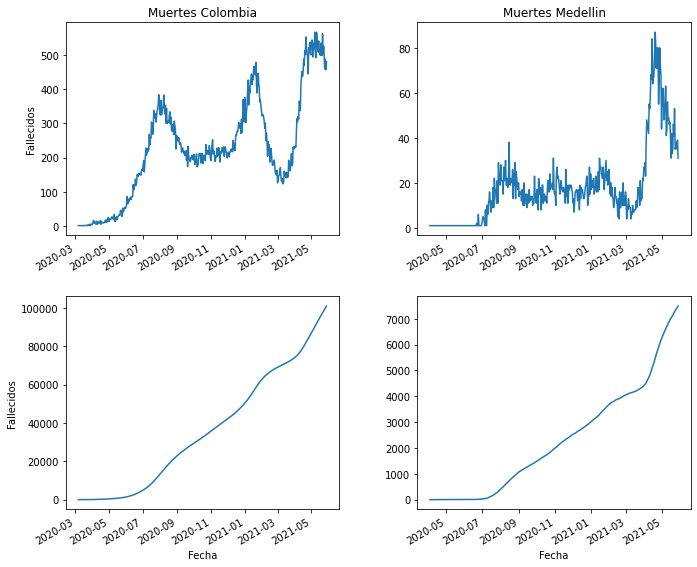

In [ ]:
# plots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(pad=1.0)

# Colombia diarias
muertes_diarias = muertes['fecha_muerte'].value_counts()
muertes_diarias.plot(ylabel='Fallecidos', title='Muertes por covid-19',figsize = (10,9), ax=axes[0,0])
# Colombia acumuladas
muertes_acum = muertes_diarias.sort_index(ascending=True).cumsum()
muertes_acum.plot(xlabel='Fecha', ylabel='Fallecidos', figsize = (10,9), ax=axes[1,0])

# Medellin diarias
muertes_medellin_diarias = muertes_medellin['fecha_muerte'].value_counts()
muertes_medellin_diarias.plot( title='Muertes por covid-19',figsize = (10,9), ax=axes[0,1])
# Medellin acumuladas
muertes_medellin_acum = muertes_medellin_diarias.sort_index(ascending=True).cumsum()
muertes_medellin_acum.plot(xlabel='Fecha', figsize = (10,9), ax=axes[1,1])

axes[0,0].set_title("Muertes Colombia")
axes[0,1].set_title("Muertes Medellin")
plt.show()

## Recuperados


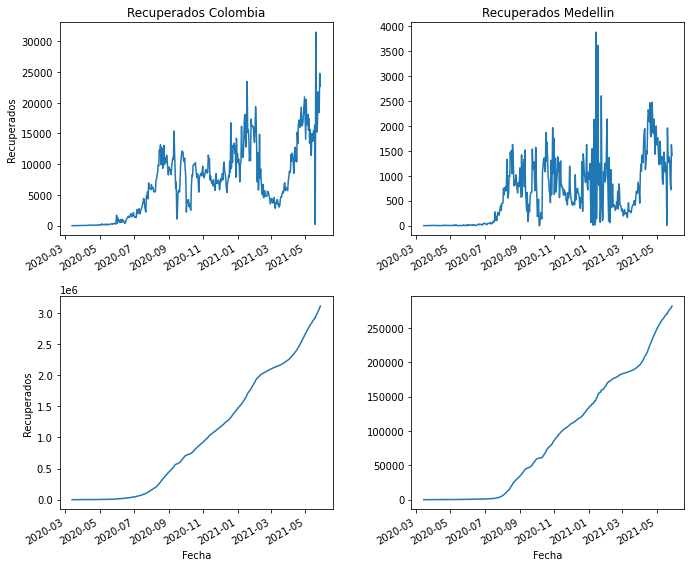

In [ ]:
# plots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(pad=1.0)

# Colombia diarios
recuperados_diarios = recuperados["fecha_recuperado"].value_counts()
recuperados_diarios.plot(ylabel='Recuperados', title='Personas recuperadas',figsize = (10,8), ax=axes[0,0])
# Colombia acumulados
recuperados_acum = recuperados_diarios.sort_index(ascending=True).cumsum()
recuperados_acum.plot(xlabel='Fecha', ylabel='Recuperados', figsize = (10,9), ax=axes[1,0])

# Medellin diarios
recuperados_medellin_diarios = recuperados_medellin["fecha_recuperado"].value_counts()
recuperados_medellin_diarios.plot(title='Personas contagiadas',figsize = (10,9), ax=axes[0,1])
# Medellin acumulados
recuperados_medellin_acum = recuperados_medellin_diarios.sort_index(ascending=True).cumsum()
recuperados_medellin_acum.plot(xlabel='Fecha', figsize = (10,9), ax=axes[1,1])

axes[0,0].set_title("Recuperados Colombia")
axes[0,1].set_title("Recuperados Medellin")
plt.show()

## Contagios
* Contagios en Colombia diarios netos y acumulados.
* Contagios en Medellin diarios netos y acumulados.

* Para el cálculo de los contagiados diarios se usó la idea de que a los contagiados anteriores netos les sumamos los contagiados del período actual y les restamos los recuperados y fallecidos del mismo.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


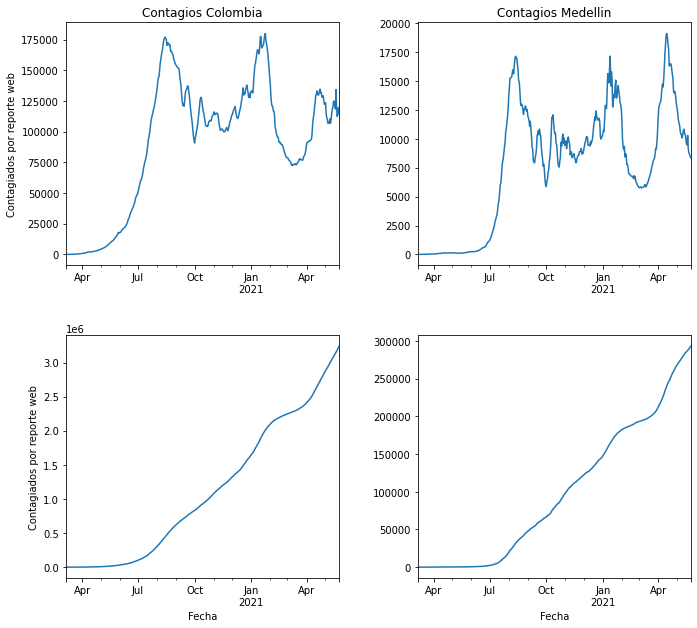

In [ ]:
# plots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(pad=1.0)

# Contagiados netos que usaremos después
contagios_diarios = contagios["fecha_reporte_web"].value_counts()
idx = pd.date_range('2020-03-06', '2021-05-24')
contagios_todas_fechas = contagios_diarios.reindex(idx, fill_value = 0)
muertes_todas_fechas = muertes_diarias.reindex(contagios_todas_fechas.sort_index().keys(), fill_value = 0)
recuperados_todas_fechas = recuperados_diarios.reindex(contagios_todas_fechas.sort_index().keys(), fill_value = 0)
contagios_netos = pd.Series()
for k,i in contagios_todas_fechas.sort_index().items():
  if pd.to_datetime('2020-03-06') == k:
    contagios_netos[k] = i
  else:
    contagios_netos[k] = i + contagios_netos[k - pd.Timedelta(days = 1)] - muertes_todas_fechas[k] - recuperados_todas_fechas[k]
# Colombia diarios
contagios_netos.plot(ylabel='Contagiados por reporte web',figsize = (10,8), ax=axes[0,0])
# Colombia acumulados
contagios_todas_fechas.cumsum().plot(xlabel='Fecha', ylabel='Contagiados por reporte web', figsize = (10,9), ax=axes[1,0]) 

# Medellin diarios
contagios_medellin_diarios = contagios_medellin["fecha_reporte_web"].value_counts()
contagios_todas_fechas_medellin = contagios_medellin_diarios.reindex(idx, fill_value = 0)
muertes_todas_fechas_medellin = muertes_medellin_diarias.reindex(contagios_todas_fechas_medellin.sort_index().keys(), fill_value = 0)
recuperados_todas_fechas_medellin = recuperados_medellin_diarios.reindex(contagios_todas_fechas_medellin.sort_index().keys(), fill_value = 0)
contagios_netos_medellin = pd.Series()
for k,i in contagios_todas_fechas_medellin.sort_index().items():
  if pd.to_datetime('2020-03-06') == k:
    contagios_netos_medellin[k] = i
  else:
    contagios_netos_medellin[k] = i + contagios_netos_medellin[k - pd.Timedelta(days = 1)] - muertes_todas_fechas_medellin[k] - recuperados_todas_fechas_medellin[k]
contagios_netos_medellin.plot(figsize = (10,9), ax=axes[0,1])
# Medellin acumulados
contagios_todas_fechas_medellin.cumsum().plot(xlabel='Fecha', figsize = (10,9), ax=axes[1,1])

axes[0,0].set_title("Contagios Colombia")
axes[0,1].set_title("Contagios Medellin")
plt.show()

## Ocupacion de Hospital/UCI

Usar la variable ubicacion nos dice en qué lugar se atendieron los casos: *Hospital, Hospital UCI, Casa* 
Por tanto, apoyados en esto, tomamos aquellos de *Hospital y Hospital UCI*.

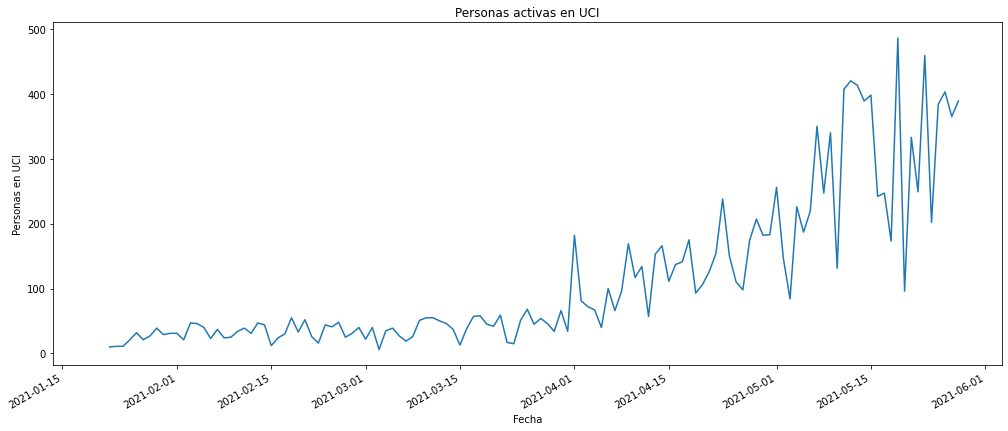

In [ ]:
# Filtrar casos de UCI
index = (Por_ubicacion['ubicacion'] == 'Hospital UCI') | (Por_ubicacion['ubicacion'] == 'Hospital')
ubicacion  = Por_ubicacion [index]

entrada_UCI = ubicacion ['fecha_reporte_web'].value_counts().sort_index().dropna()
recuperadosUCI_diarios = ubicacion ['fecha_recuperado'].value_counts().sort_index().dropna() 
# Calculamos el flujo como la diferencia entre aquellos que entran y los que se recuperan.
UCI = entrada_UCI - recuperadosUCI_diarios

# Graficar
UCI.plot(xlabel='Fecha', ylabel='Personas en UCI', title='Personas activas en UCI', figsize=(17,7))
plt.show()

#### Flujos de entrada/salida a Hospital/UCI
Contraste de la entrada y salida de pacientes a UCI.

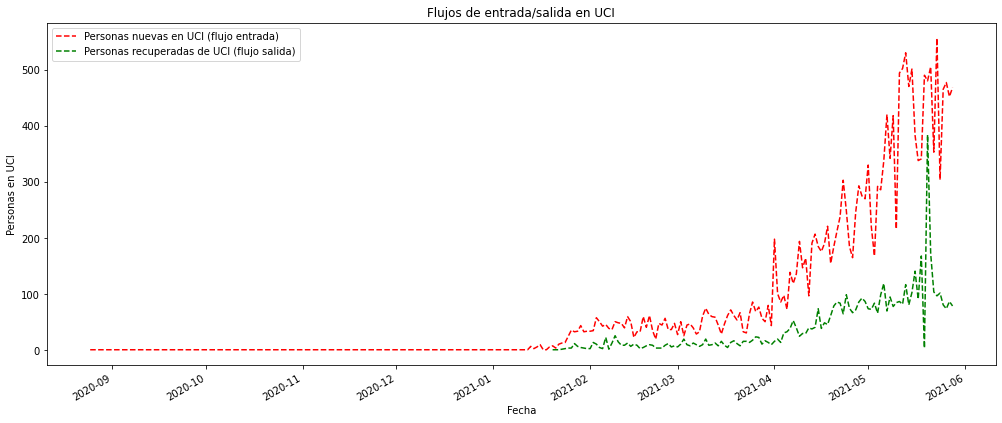

In [ ]:
# plot
plt.figure(figsize=(17,7))
entrada_UCI.plot(style="r--", xlabel='Fecha', ylabel='Personas en UCI', label='Personas nuevas en UCI (flujo entrada)')
recuperadosUCI_diarios.plot(style="g--", label='Personas recuperadas de UCI (flujo salida)')
plt.legend()
plt.title('Flujos de entrada/salida en UCI')
plt.show()

# Información por edades y sexo

Informacion que se podría usar para mejorar el modelo en aspectos de estimación o inclusión de variables como sexo.

## Histogramas de datos

####  Por edad

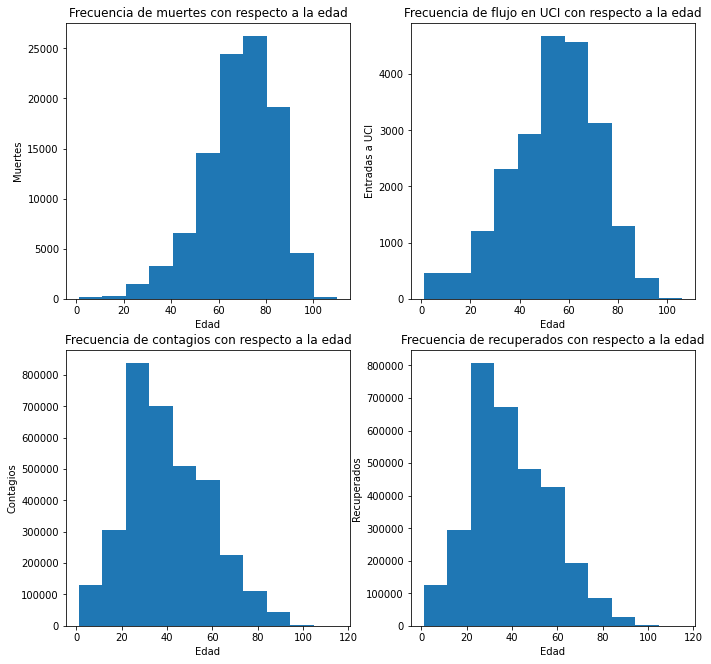

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,9.5))
fig.tight_layout(pad=3.0)

axes[0,0].hist(muertes["edad"], bins=11)
axes[0,0].set_xlabel("Edad") 
axes[0,0].set_ylabel("Muertes")

axes[0,1].hist(ubicacion["edad"], bins=11)
axes[0,1].set_xlabel("Edad") 
axes[0,1].set_ylabel("Entradas a UCI")

axes[1,0].hist(contagios["edad"], bins=11)
axes[1,0].set_xlabel("Edad") 
axes[1,0].set_ylabel("Contagios") 

axes[1,1].hist(recuperados["edad"], bins=11)
axes[1,1].set_xlabel("Edad") 
axes[1,1].set_ylabel("Recuperados") 


axes[0,0].set_title("Frecuencia de muertes con respecto a la edad")
axes[0,1].set_title("Frecuencia de flujo en UCI con respecto a la edad")
axes[1,0].set_title("Frecuencia de contagios con respecto a la edad")
axes[1,1].set_title("Frecuencia de recuperados con respecto a la edad")

plt.show()

#### Por sexo


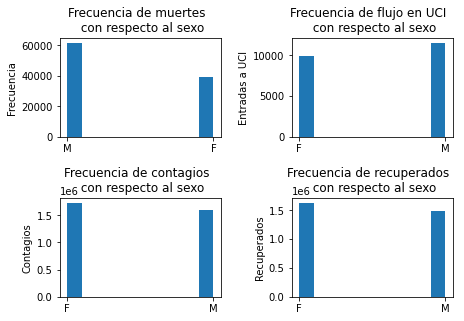

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,5))
fig.tight_layout(pad=4)

axes[0,0].hist(muertes["sexo"])
axes[0,0].set_ylabel("Frecuencia")

axes[0,1].hist(ubicacion["sexo"])
axes[0,1].set_ylabel("Entradas a UCI")

axes[1,0].hist(contagios["sexo"])
axes[1,0].set_ylabel("Contagios") 

axes[1,1].hist(recuperados["sexo"])
axes[1,1].set_ylabel("Recuperados") 


axes[0,0].set_title("Frecuencia de muertes  \n con respecto al sexo")
axes[0,1].set_title("Frecuencia de flujo en UCI  \n con respecto al sexo")
axes[1,0].set_title("Frecuencia de contagios  \n con respecto al sexo")
axes[1,1].set_title("Frecuencia de recuperados  \n con respecto al sexo")

plt.show()

## Frecuencias relativas

####  Por edad

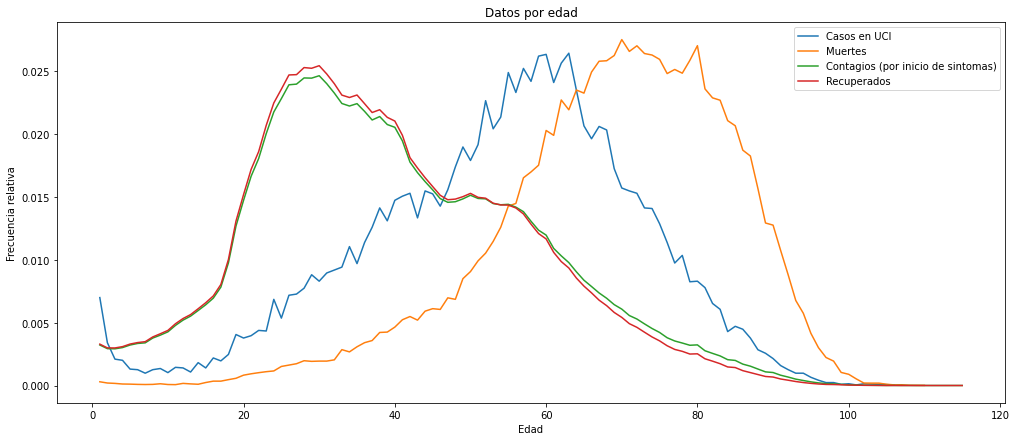

In [ ]:
contagios_porEdad = contagios["edad"].value_counts().sort_index()
total_contagios = contagios_porEdad.sum()

recuperados_porEdad  = recuperados["edad"].value_counts().sort_index()
total_recuperados = recuperados_porEdad.sum()

muertes_porEdad  = muertes["edad"].value_counts().sort_index()
total_muertes = muertes_porEdad.sum()

enHosp_porEdad = ubicacion["edad"].value_counts().sort_index()
total_enUCI = enHosp_porEdad.sum()

plt.figure(figsize=(17,7))

plt.plot(enHosp_porEdad/total_enUCI, label = "Casos en UCI")
plt.plot(muertes_porEdad/total_muertes, label = "Muertes")
plt.plot(contagios_porEdad/total_contagios, label = "Contagios (por inicio de sintomas)")
plt.plot(recuperados_porEdad/total_recuperados, label = "Recuperados")

plt.title("Datos por edad")
plt.xlabel("Edad") 
plt.ylabel("Frecuencia relativa")
plt.legend()
plt.show()

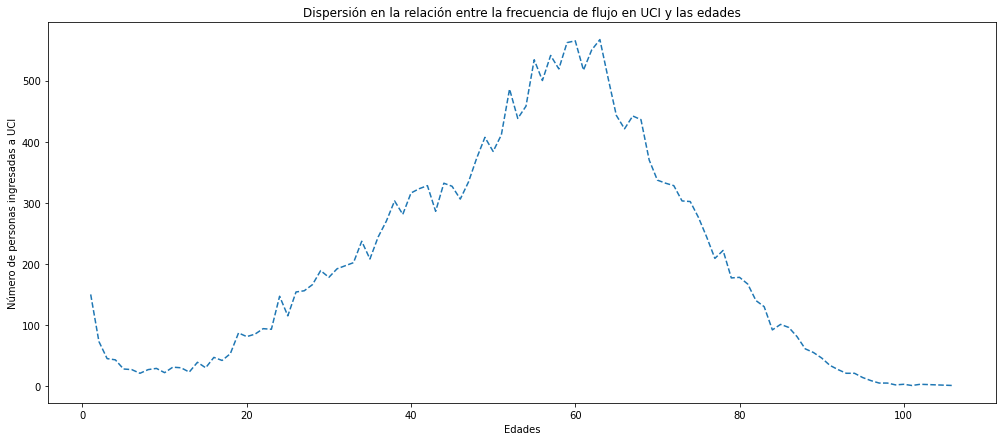

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(ubicacion["edad"].value_counts().sort_index(), '--')
plt.title("Dispersión en la relación entre la frecuencia de flujo en UCI y las edades")
plt.xlabel("Edades")
plt.ylabel("Número de personas ingresadas a UCI")
plt.show()

#### Por sexo

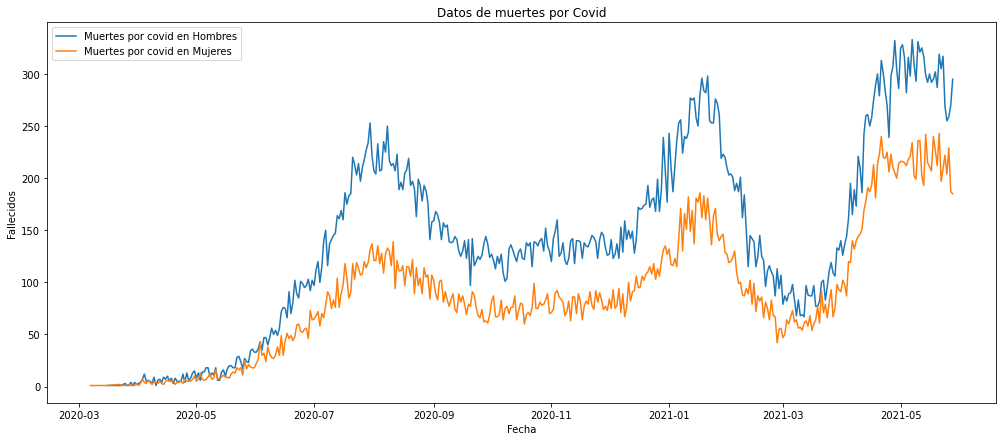

In [ ]:
contagios_F = contagios[contagios["sexo"]=="F"]["fecha_reporte_web"].value_counts().sort_index()
contagios_M = contagios[contagios["sexo"]=="M"]["fecha_reporte_web"].value_counts().sort_index()

recuperados_F = recuperados[recuperados["sexo"]=="F"]["fecha_recuperado"].value_counts().sort_index()
recuperados_M = recuperados[recuperados["sexo"]=="M"]["fecha_recuperado"].value_counts().sort_index()

muertes_F = muertes[muertes["sexo"]=="F"]["fecha_muerte"].value_counts().sort_index()
muertes_M = muertes[muertes["sexo"]=="M"]["fecha_muerte"].value_counts().sort_index()

enHosp_F = ubicacion[ubicacion["sexo"]=="F"]["fecha_reporte_web"].value_counts().sort_index()
enHosp_M = ubicacion[ubicacion["sexo"]=="M"]["fecha_reporte_web"].value_counts().sort_index()

plt.figure(figsize=(17,7))
plt.plot(muertes_M, label = "Muertes por covid en Hombres")
plt.plot(muertes_F, label = "Muertes por covid en Mujeres")

plt.title("Datos de muertes por Covid")
plt.xlabel("Fecha") 
plt.ylabel("Fallecidos")
plt.legend()
plt.show()

# Epidemiología matemática
Para el entendimiento del fenómeno de la pandemia, se emplearon principalmente el modelo SIR y el SEIRD.

## Parámetros usados
Para poder resolver las ecuaciones, debemos conocer los parámetros o, en este caso, realizar una estimación.

### Estimación de tasa de mortalidad

Calcular la tasa de mortalidad de la enfermedad ponderando la mortalidad por edades segun la densidad poblacional de cada grupo etario de contagiados.

In [ ]:
# Agrupamos los datos de fallecidos por edad
valores_muertes_agrupados = muertes["edad"].value_counts(bins = 11).sort_index()
# Agrupamos la población por edad
valores_edades_agrupados = Data_trans["edad"].value_counts(bins = valores_muertes_agrupados.keys()).sort_index()

# Tasa de mortalidad por grupo etario
tasa_muertes_agrupados = valores_muertes_agrupados/valores_edades_agrupados
# Proporción poblacional por edades
proporciones_edades_agrupados = valores_edades_agrupados/len(Data_trans["edad"])
proporciones_edades_agrupados

(0.89, 10.909]       0.034122
(10.909, 20.818]     0.079994
(20.818, 30.727]     0.220891
(30.727, 40.636]     0.220063
(40.636, 50.545]     0.160194
(50.545, 60.455]     0.138624
(60.455, 70.364]     0.082946
(70.364, 80.273]     0.041455
(80.273, 90.182]     0.018297
(90.182, 100.091]    0.003305
(100.091, 110.0]     0.000107
Name: edad, dtype: float64

Extraemos ahora las proporciones de muertes y poblacionales por edad.

In [ ]:
# Proporciones poblacionales.
aux = list(proporciones_edades_agrupados.items())
prop_edades = np.array(list(map(lambda x: x[:][1],aux)))

# Tasas de mortalidad por edad
aux2 = list(tasa_muertes_agrupados.items())
tasas_muertes = np.array(list(map(lambda x: x[:][1], aux2)))

# Estimación tasa de mortalidad global
tasa = np.dot(prop_edades,tasas_muertes)
tasa

0.02992561963620254

### R0

$\beta$ y $\gamma$ son cantidades mayores a cero y representan la tasa de transmisión y la tasa de recuperación. Estas dos cantidades se relacionan junto con N (la población total) para definir:
$$R_0=N(\frac{\beta}{\gamma})$$

A partir de lo planteado en el documento en el cual se cita de dónde se tomó la idea para usar funciones con un comportamiento en forma de "S" para modelar el $R_0$, con la necesidad de que sea dependiente del tiempo. De esta manera contrastamos dos posibles funciones:

* Función logística.
* Función de Gompertz.

#### Como una función logística
La función logística correspondiente es:
$$R_0(t)=\frac{R_{0_{start}}-R_{0_{end}}}{1+e^{-k(-t+t_0)}}+R_{0_{end}}$$

In [ ]:
def R_0(x, R0start, R0end, x0, k):    
    return (R0start - R0end)/(1 + np.exp(-k*(-x+x0))) + R0end

#### Como una función de Gompertz
La función de Gompertz correspondiente es:

$$R_0(t)=R_{0_{start}}e^{-e^{k(t-t_0)}} + R_{0_{end}}$$

In [ ]:
def R_0_G(x, R0start, R0end, x0, k):
  return R0start*np.exp(-np.exp(k*(x-x0))) + R0end

### Beta dependiente del tiempo

Ahora bien, tomemos también $\beta$ como una variable dependiente del tiempo y podemos definirla como:
$$ \beta(t) = \frac{\gamma R_0(t)}{N} $$

In [ ]:
def beta(t):
  return R_0(t,2.28, 1.75, 20, 0.5)*gamma/(50*10**6)      # por R0 logistico
  #return R_0_G(t,2.28, 1.75, 20, 0.5)*gamma/(50*10**6)    # por R0 de Gompertz

### Valores de fechas
* Se calcula el intervalo de tiempo o número de días de los cuales se tiene información.

In [ ]:
fechas = muertes_todas_fechas.sort_index().keys()
diferencia = fechas[-1] - fechas[0]
dias = diferencia/np.timedelta64(1,'D') + 1
t = np.arange(0,int(dias), 1)

## Modelo SIR

El modelo SIR empleado está descrito por las ecuaciones:
$$
\begin{align}
\frac{dS}{dt} & = -\beta(t) \cdot I(t) \cdot S(t) \\
\frac{dI}{dt} & = \beta(t) \cdot I(t) \cdot S(t) - \gamma \cdot I(t) \\
\frac{dR}{dt} & = \gamma \cdot I(t) \\
S + I + R & = N \\
\end{align}
$$

Donde: 
* S: es el conjunto de individuos susceptibles en un instante t.
* I: es la cantidad de personas contagiadas en un instante t.
* R: cantidad de recuperados en un instante t.
* $\beta$ : tasa de transmisión.
* $\gamma$ : tasa de recuperación.

In [ ]:
def ecuaciones_SIR(y,t,beta,gamma):
  S,I,R = y 
  dSdt = -beta(t)*S*I
  dIdt = beta(t)*S*I - gamma*I
  dRdt = gamma*I
  return dSdt, dIdt, dRdt

In [ ]:
# Parámetros:
N = 50*10**6
gamma = 1/15

# Condiciones iniciales: 1 infectado
S0, I0, R0 = N-1, 1, 0 
y0 = S0, I0, R0

# Solucion
solucion = odeint(ecuaciones_SIR, y0, t, args = (beta, gamma))
S,I,R = solucion.T

### Simulación a Mayo 2021

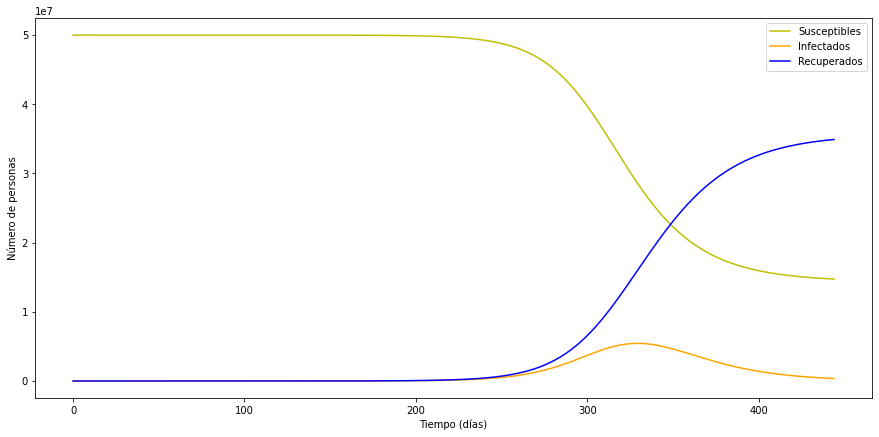

In [ ]:
# Gráfica resultados hasta Mayo 2021
plt.figure(figsize=(15,7))
plt.plot(t, S, 'y', label = "Susceptibles")
plt.plot(t, I, color = 'orange', label = "Infectados")
plt.plot(t, R, 'b', label = "Recuperados")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

### Simulación de 1000 días
Para tener una observación completa el fenómeno y su duración, resolvemos para más días.

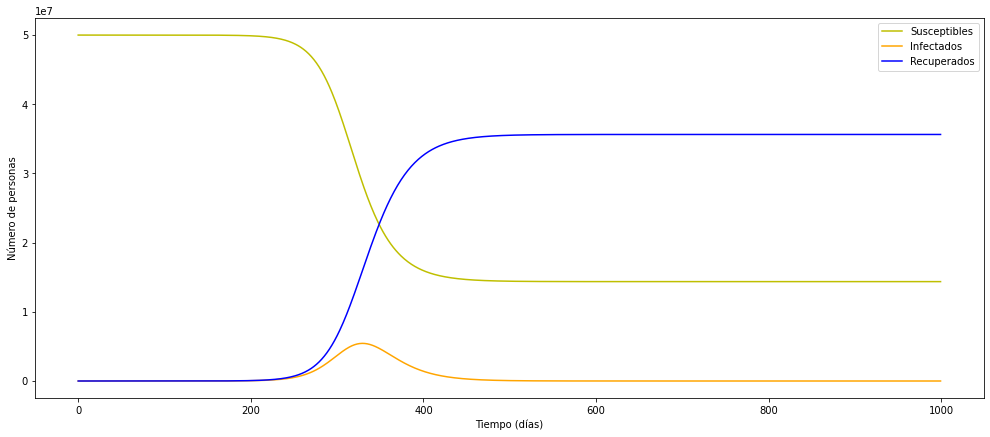

In [ ]:
# Solucion
t2 = np.arange(0,1000,1)
solucion = odeint(ecuaciones_SIR, y0, t2, args = (beta, gamma))
S2,I2,R2 = solucion.T

# Gráfica 1000 días
plt.figure(figsize=(17,7))
plt.plot(t2, S2, 'y', label = "Susceptibles")
plt.plot(t2, I2, color = 'orange', label = "Infectados")
plt.plot(t2, R2, 'b', label = "Recuperados")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

### Ajuste a infectados históricos

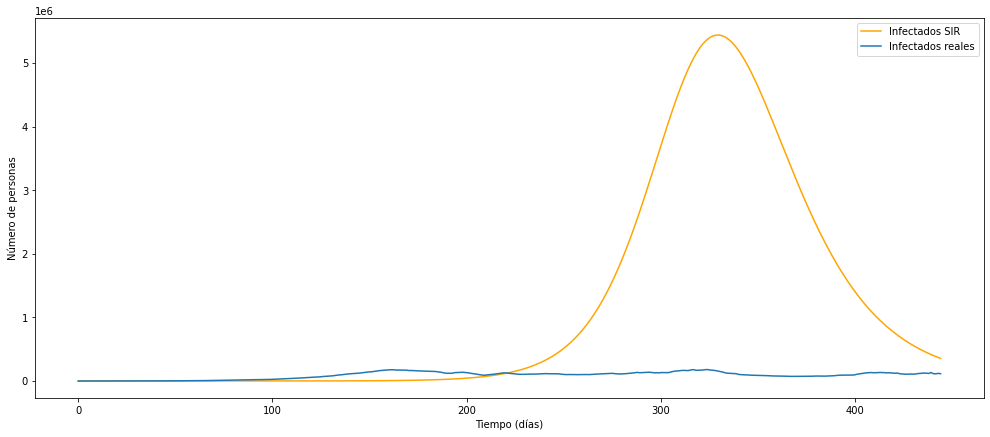

In [ ]:
# Plot contagiados históricos y curva I del modelo SIR
plt.figure(figsize=(17,7))
plt.plot(t, I, color = 'orange', label = "Infectados SIR")
plt.plot(t, contagios_netos, label = "Infectados reales")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

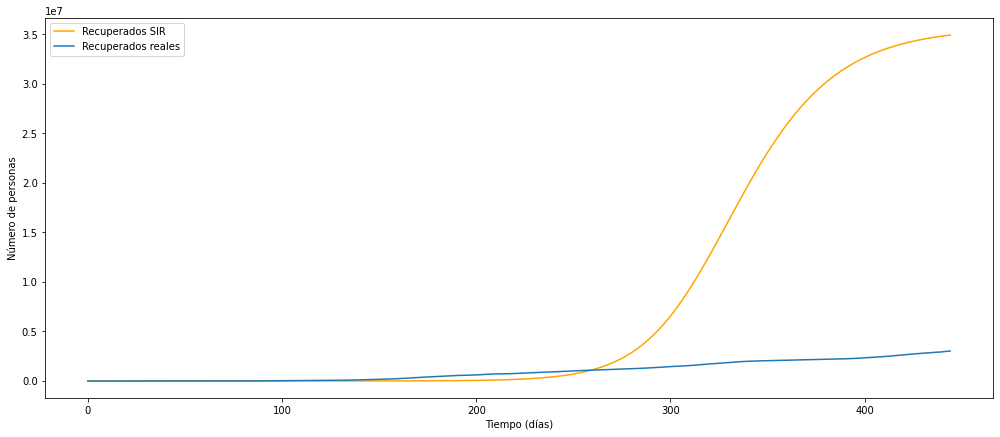

In [ ]:
# Plot recuperados históricos y curva R del modelo SIR
plt.figure(figsize=(17,7))
plt.plot(t, R, color = 'orange', label = "Recuperados SIR")
plt.plot(t, recuperados_todas_fechas.cumsum(), label = "Recuperados reales")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

## Modelo SEIRD
Al modelo SIR le añadimos *Expuestos y Decesos*:
$$
\begin{align}
\frac{dS}{dt} & = -\beta(t) \cdot I(t) \cdot S(t) \\
\frac{dE}{dt} & = \beta(t) \cdot S(t) \cdot I(t) \\
\frac{dI}{dt} & = \delta \cdot E(t) - (1-\alpha) \cdot \gamma \cdot I(t) - \alpha \rho I(t) \\
\frac{dR}{dt} & = (1-\alpha)\cdot \gamma \cdot I(t) \\
\frac{dD}{dt} & = \alpha \rho I(t) \\
S + E + I + R + D & = N \\
\end{align}
$$

Donde: 
* S: es el conjunto de individuos susceptibles en un instante t.
* E: cantidad de expuestos en el instante t.
* I: es la cantidad de personas contagiadas en un instante t.
* R: cantidad de recuperados en un instante t.
* D: decesos en el instante t.
* $\beta$ : tasa de transmisión.
* $\gamma$ : tasa de recuperación.
* $\delta$ : período de incubación.
* $\alpha$ : Tasa de mortalidad.
* $\rho$ : Tasa de infectado a fallecido.

In [ ]:
def ecuaciones_SEIRD(y,t,beta,gamma,alpha,rho,delta):
  S,E,I,R,D = y 
  dSdt = -beta(t)*S*I
  dEdt = beta(t)*S*I-delta*E
  dIdt = delta*E - (1-alpha)*gamma*I - alpha*rho*I
  dRdt = (1-alpha)*gamma*I
  dDdt = alpha*rho*I
  return dSdt, dEdt, dIdt, dRdt, dDdt

In [ ]:
# Parámetros:
N = 50*10**6
gamma = 1/15
alpha = tasa
rho = 1/14
delta = 1/5.2

# Condiciones iniciales:
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0 # 1 expuesto.
y0 = S0, E0, I0, R0, D0 

# Solucion:
solucion = odeint(ecuaciones_SEIRD, y0, t, args = (beta, gamma, alpha, rho, delta))
S,E,I,R,D = solucion.T

### Simulación a Mayo 2021


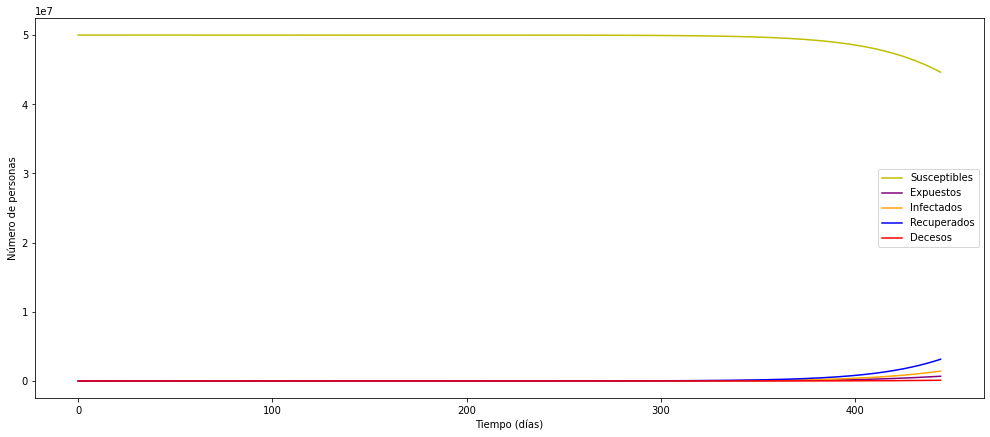

In [ ]:
# Plot
plt.figure(figsize=(17,7))
plt.plot(t, S, 'y', label = "Susceptibles")
plt.plot(t, E, color = 'purple', label = "Expuestos")
plt.plot(t, I, color = 'orange', label = "Infectados")
plt.plot(t, R, 'b', label = "Recuperados")
plt.plot(t, D, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

### Simulación de 1000 días
Para tener una observación completa el fenómeno y su duración, resolvemos para más días.

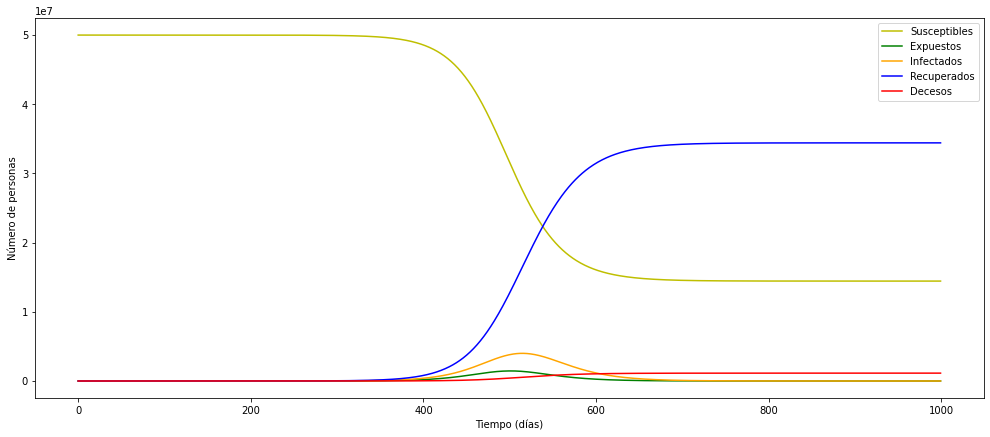

In [ ]:
# solucion
t2 = np.arange(0,1000,1)
solucion = odeint(ecuaciones_SEIRD, y0, t2, args = (beta, gamma, alpha, rho, delta))
S2,E2,I2,R2,D2 = solucion.T

# Gráfica 1000 días:
plt.figure(figsize=(17,7))
plt.plot(t2, S2, 'y', label = "Susceptibles")
plt.plot(t2, E2, 'g', label = "Expuestos")
plt.plot(t2, I2, color = 'orange', label = "Infectados")
plt.plot(t2, R2, 'b', label = "Recuperados")
plt.plot(t2, D2, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

### Ajuste a infectados historicos

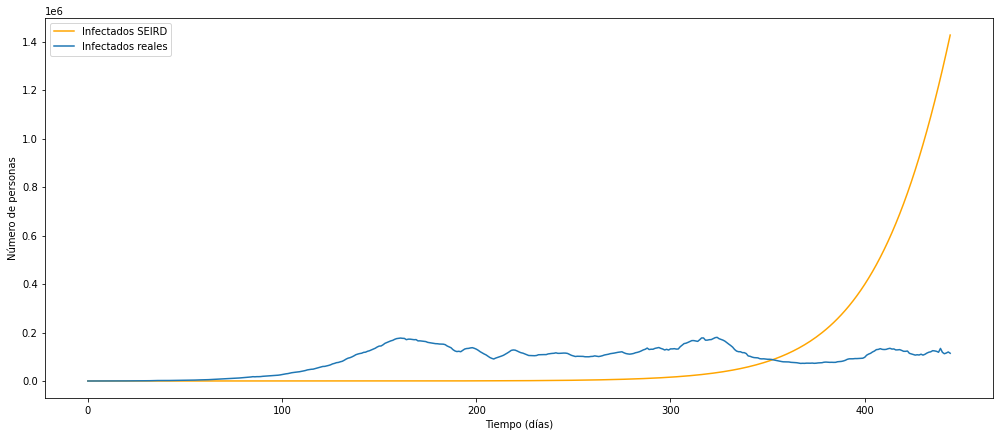

In [ ]:
# Plot contagiados históricos y curva I del modelo SEIRD
plt.figure(figsize=(17,7))
plt.plot(t, I, color = 'orange', label = "Infectados SEIRD")
plt.plot(t, contagios_netos, label = "Infectados reales")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

### Ajuste al historico de muertes

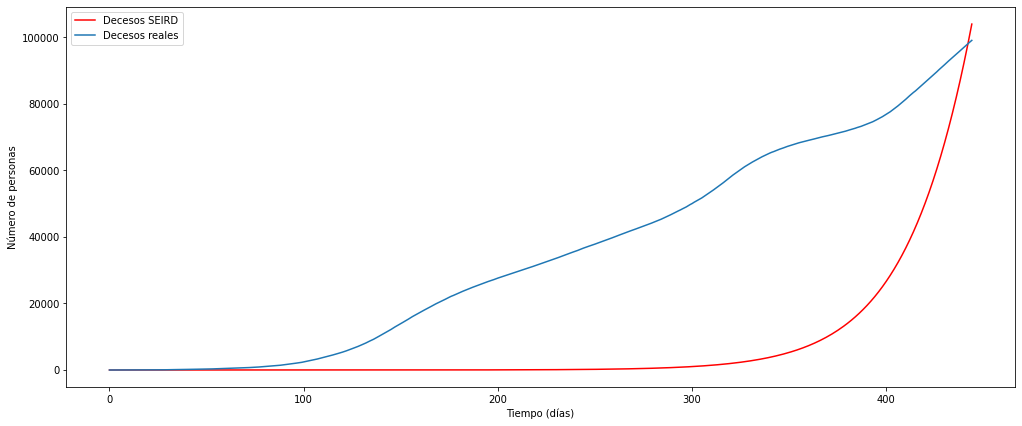

In [ ]:
# Plot fallecidos históricos y curva D del modelo SEIRD
plt.figure(figsize=(17,7))
plt.plot(t, D, 'r', label = "Decesos SEIRD")
plt.plot(t, muertes_todas_fechas.cumsum(), label = "Decesos reales")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

### Ajuste al historico de recuperados

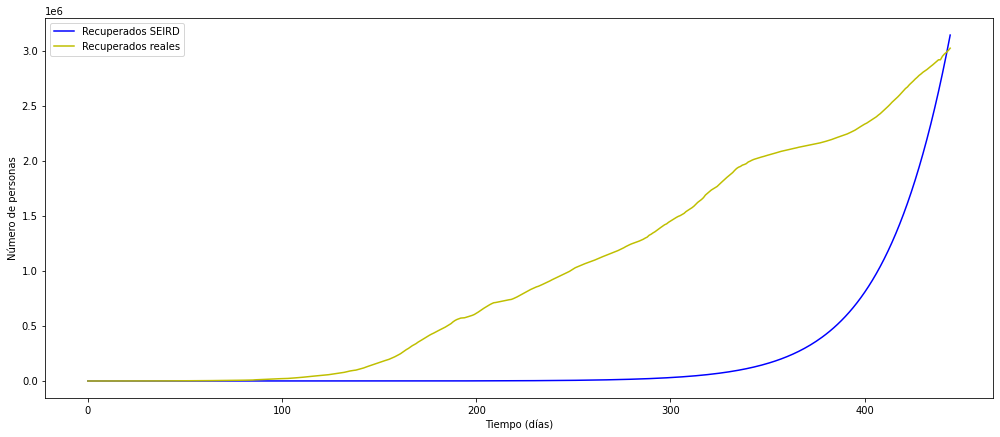

In [ ]:
# Plot recuperados históricos y curva R del modelo SEIRD
plt.figure(figsize=(17,7))
plt.plot(t, R, 'b', label = "Recuperados SEIRD")
plt.plot(t, recuperados_todas_fechas.cumsum(), 'y',label = "Recuperados reales")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

# Ajuste de curvas
Para realizar esta sección, se apoyó en el método de Mínimos Cuadrados no lineales; para ello, se usa la librería *lmfit* que a través del algoritmo de Levenberg-Marquardt logran llegar a un óptimo local. Tendremos los ajustes a los niveles:
* Muertes.
* Infectados.
* Recuperados.

Además, como criterio para observar la significancia del modelo, se utilizó el coeficiente de determinación o R- cuadrado, que se define como:

$$ R^2 := 1 - \frac{\text{Suma de cuadrados residuales}}{\text{Suma de cuadrados totales}} $$

Y con este, realizaremos el test de hipótesis:

$$ H_0: \text{El modelo no es estadísticamente significativo} $$
$$ H_1: \text{El modelo es estadísticamente significativo} $$

Usando el estadístico:

$$ F = \frac{R^2/(k-1)}{R^2/(n-k)} \tilde{} F_{k-1, n-k}$$
Donde $k$ es el número de parámetros y $n$ la cantidad de observaciones. El p-valor es calculado como:
 $$\text{p-valor} = P(F > F_{k-1, n-k})$$

## Modelo SEIRD

In [ ]:
def Model_SEIRD(dias, R0start, R0end, x0, k):
  # Beta dependiente del tiempo
  def beta(t):
    return R_0(t,R0start, R0end, x0, k)*gamma/(50*10**6)

  # Condiciones iniciales: una persona expuesta.
  y0 = N-1.0, 1.0, 0.0, 0.0, 0.0 
  t = np.arange(0,int(dias), 1)

  # solucion
  solucion = odeint(ecuaciones_SEIRD, y0, t, args = (beta, gamma, alpha, rho, delta))
  S,E,I,R,D = solucion.T
  
  R0_comportamiento = [beta(i)/gamma for i in range(len(t))]  #Útil para realizar gráfica de su comportamiento.
  return t, S, E, I, R, D, R0_comportamiento

### Ajuste de muertes

In [ ]:
def ajuste_muertes(x, R0start, R0end, x0, k):
  respuestas = Model_SEIRD(dias, R0start, R0end, x0, k)
  muertes_SEIRD_ajuste = respuestas[5]
  return muertes_SEIRD_ajuste[x]

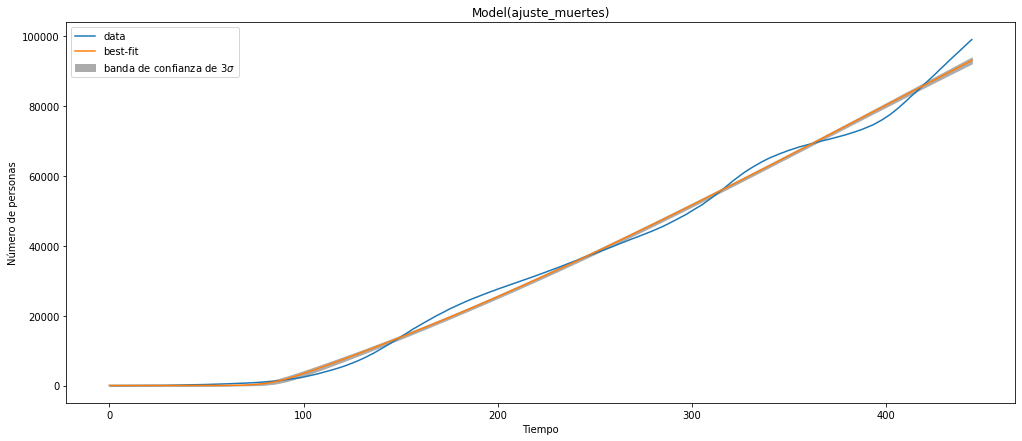

El modelo tiene un r^2 de: 0.996609227895468


In [ ]:
# Setup
metodo = "leastsq"
modelo_muertes = lmfit.Model(ajuste_muertes)
param = {"R0start": 2.5, "k": 0.2, "x0": 80, "R0end": 1.0}
for k, i in param.items():
  modelo_muertes.set_param_hint(str(k), value = i, vary = True)
parametros = modelo_muertes.make_params()

# Ajuste por lmfit usando Mínimos Cuadrados no lineales
muertes_todas_fechas = muertes_diarias.reindex(contagios_todas_fechas.sort_index().keys(), fill_value = 0)
resultado = modelo_muertes.fit(muertes_todas_fechas.cumsum(), parametros, method=metodo, x=t)

# Resultados del ajuste
plt.figure(figsize=(17,7))
dely = resultado.eval_uncertainty(sigma=3)
resultado.plot_fit(datafmt="-")

# Graficando incertidumbre a 3-sigma.
plt.fill_between(t, resultado.best_fit-dely, resultado.best_fit+dely, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$')
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Número de personas")
plt.show()

#Coeficiente de determinación o R^2
Rcuadrado = 1 - resultado.residual.var()/np.var(muertes_todas_fechas.cumsum())
print("El modelo tiene un r^2 de: " + str(Rcuadrado))

# Se imprimen datos generales de los resultados
resultado

In [ ]:
# Intervalo de confianza para los parámetros estimados
print(resultado.ci_report())

            99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 R0start:  -0.56323  -0.46952  -0.35710   5.65617  +0.53527  +1.36240  +2.70556
 R0end  :  -0.00501  -0.00333  -0.00156   1.05742  +0.00166  +0.00330  +0.00494
 x0     : -27.59899 -16.49001  -7.50564  80.43399  +6.30438  +8.15441  +9.81012
 k      :  -0.14519  -0.12566  -0.09071   0.21906      +inf      +inf      +inf


/usr/local/lib/python3.7/dist-packages/lmfit/confidence.py:334: UserWarning: rel_change=-9.311542176117723e-05 < 1e-05 at iteration 89 and prob(k=4.116236248434832) = 0.507899886361032 < max(sigmas).
  warn(errmsg)


In [ ]:
from scipy.stats import f
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado/3)/((1-Rcuadrado)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

### Ajuste de contagios

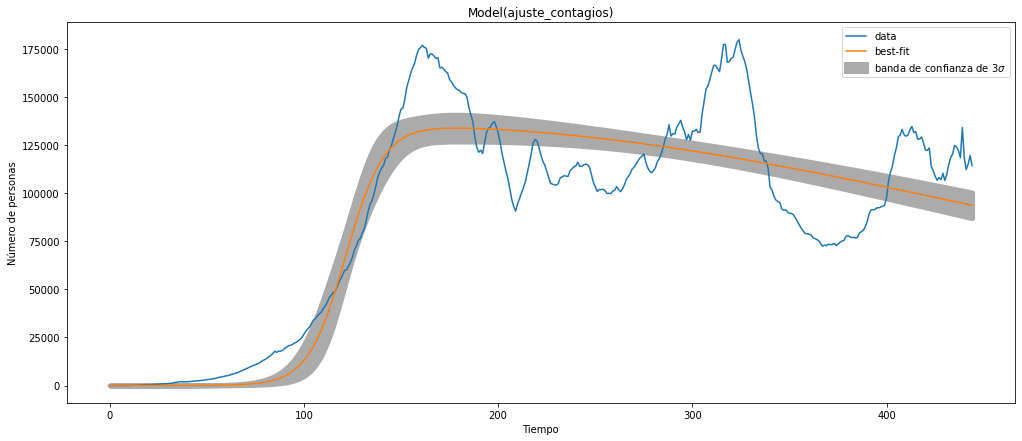

El modelo tiene un r^2 de: 0.8320492378592612


In [ ]:
def ajuste_contagios(x, R0start, R0end, x0, k):
  respuestas = Model_SEIRD(dias, R0start, R0end, x0, k)
  muertes_SEIRD_ajuste = respuestas[3]
  return muertes_SEIRD_ajuste[x]

# Setup
param = {"R0start": 3.0, "k": 0.1, "x0": 80.0, "R0end": 1.0}
metodo = "leastsq"
modelo_contagios = lmfit.Model(ajuste_contagios)
for k, i in param.items():
  modelo_contagios.set_param_hint(str(k), value = i, vary = True)
parametros_contagio = modelo_contagios.make_params()

# Ajuste por lmfit usando Mínimos Cuadrados no lineales
resultado_contagios = modelo_contagios.fit(contagios_netos, parametros_contagio, method=metodo, x=t)

# Resultados del ajuste
plt.figure(figsize=(17,7))
dely2 = resultado_contagios.eval_uncertainty(sigma=3)
resultado_contagios.plot_fit(datafmt="-")

# Graficando incertidumbre a 3-sigma.
plt.fill_between(t, resultado_contagios.best_fit-dely2, resultado_contagios.best_fit+dely2, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth=5)
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Número de personas")
plt.show()

#Coeficiente de determinación o R^2
Rcuadrado_contagios = 1 - resultado_contagios.residual.var()/np.var(contagios_netos)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_contagios))

# Se imprimen datos generales de los resultados
resultado_contagios

In [ ]:
# Intervalos de confianza de los parámetros
print(resultado_contagios.ci_report())

            99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 R0start:  -0.27869  -0.20042  -0.10874   3.97406  +0.13293  +0.29920  +0.51494
 R0end  :  -0.00812  -0.00537  -0.00264   1.01039  +0.00265  +0.00529  +0.00793
 x0     : -15.23900  -9.39068  -4.38132 115.78562  +3.68544  +7.35178 +10.48970
 k      :  -0.03931  -0.02887  -0.01614   0.10958  +0.02142  +0.05207  +0.10155


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_contagios/3)/((1-Rcuadrado_contagios)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

### Ajuste de recuperados

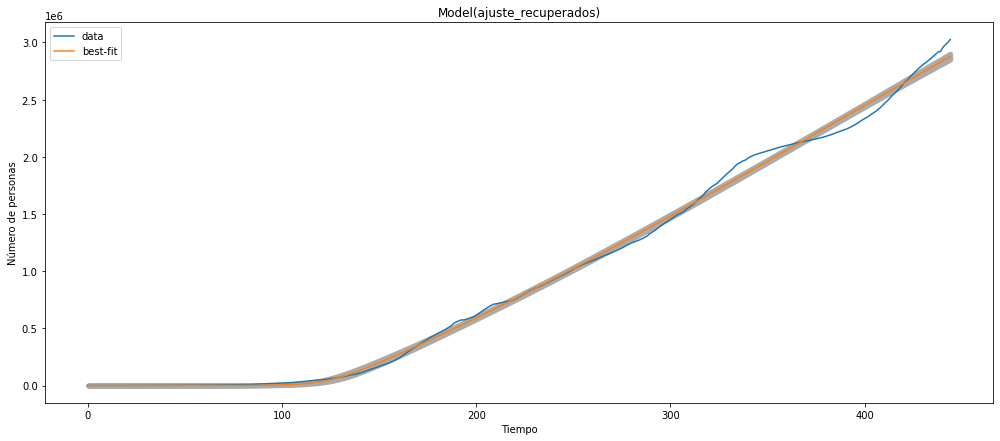

El modelo tiene un r^2 de: 0.9972069650927714


In [ ]:
def ajuste_recuperados(x, R0start, R0end, x0, k):
  respuestas = Model_SEIRD(dias, R0start, R0end, x0, k)
  recuperados_SEIRD_ajuste = respuestas[4]
  return recuperados_SEIRD_ajuste[x]

# Setup
metodo = "leastsq"
modelo_recuperados = lmfit.Model(ajuste_recuperados)
for k, i in param.items():
  modelo_recuperados.set_param_hint(str(k), value = i, vary = True)
parametros_recuperados = modelo_recuperados.make_params()

# Ajuste por lmfit usando Mínimos Cuadrados no lineales
resultado_recuperados = modelo_recuperados.fit(recuperados_todas_fechas.cumsum(), parametros_recuperados, method=metodo, x=t)

# Resultados del ajuste
plt.figure(figsize=(17,7))
dely3 = resultado_recuperados.eval_uncertainty(sigma=3)
resultado_recuperados.plot_fit(datafmt="-")
# Graficando incertidumbre a 3-sigma.
plt.fill_between(t, resultado_recuperados.best_fit-dely3, resultado_recuperados.best_fit+dely3, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 5)
plt.xlabel("Tiempo")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_recuperados = 1 - resultado_recuperados.residual.var()/np.var(recuperados_todas_fechas.cumsum())
print("El modelo tiene un r^2 de: " + str(Rcuadrado_recuperados))

# Se imprimen datos generales de los resultados
resultado_recuperados

In [ ]:
#Intervalo de confianza de los parámetros
print(resultado_recuperados.ci_report())

            99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 R0start:  -0.23517  -0.19813  -0.11911   3.75321  +0.15659  +0.37405  +0.69125
 R0end  :  -0.00593  -0.00383  -0.00184   1.05488  +0.00177  +0.00372  +0.00561
 x0     : -22.81019 -13.59349  -6.14809 121.63992  +5.32486  +9.29790 +11.01866
 k      :  -0.08023  -0.06539  -0.04249   0.13965      +inf      +inf      +inf


/usr/local/lib/python3.7/dist-packages/lmfit/confidence.py:334: UserWarning: rel_change=-0.40221002715085513 < 1e-05 at iteration 8 and prob(k=0.15594991361124408) = 0.17624288425218226 < max(sigmas).
  warn(errmsg)


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_recuperados/3)/((1-Rcuadrado_recuperados)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

## Ajuste de curvas obtenidas

Ahora, haremos el ejercicio de ajustar las curvas obtenidas a diferentes funciones para tener así una modelo más claro.

### Funciones para realizar ajustes

Las funciones que se utilizaron para realizar esto son la Gompertz:
$$ f(t) = ae^{-be^{-ct}} $$

La logística de la familia de las sigmoides de la forma:
$$ f(t) = a + \frac{b}{1 + e^{-(t-c)/d}} $$

Una doble sigmoide asimétrica (ADS):

$$f(t) = a + \left(\frac{b}{a + exp\left(-\frac{t- c + d/2}{e}\right)}\right)\left(1 - \frac{1}{1 + exp\left(- \frac{t - c + d/2}{f}\right)}\right)$$

Y una logística con potencia (LgstcPowPk):
$$f(t) = a + b \left[(1 + \eta)^{-\frac{e+1}{e}}\right]\left[\frac{\eta(e+1)^{\frac{e+1}{e}}}{e} \right]$$

Donde
$$\eta = exp\left(\frac{e + dln(e) - c}{d}\right) $$

In [ ]:
def gompertz(t,a,b,c):
  return a*np.exp(-b*np.exp(-c*t))

def sigmoide(t,a,b,c,d):
  return a + b/(1 + np.exp(-(t-c)/d))

def ADS(t,a,b,c,d,e,f):
  return a + b/(1+np.exp(- (t - c + d/2)/e))*(1 - 1/(1+ np.exp(- (t - c - d/2)/f)))

def eta(t,c,d,e):
  return np.exp((t+d*np.log(e)-c)/d)

def lgstcPowPk(t,a,b,c,d,e):
  return a + b*((1+eta(t,c,d,e))**(-(e+1)/e))*(eta(t,c,d,e)*(e+1)**(e+1/e)/e)

### Ajuste muertes 

Para este caso utilizamos funciones tipo "S", es decir la sigmoide y la Gompertz

In [ ]:
# Extraemos parámetros del mejor ajuste a curva de muertes
valores = list(map(lambda x: x[:][1],list(resultado.best_values.items())))
valores

[5.656169297375512, 1.0574236963030819, 80.43398608042872, 0.21905577742636284]

In [ ]:
# Nuevo Beta dependiente del tiempo
def nuevo_beta(t):
  return R_0(t,valores[0], valores[1], valores[2], valores[3])*gamma/(50*10**6)
# Nuevas ecuaciones
def nuevas_ecuaciones_SEIRD(y,t,beta,gamma,alpha,rho,delta):
  S,E,I,R,D = y 
  dSdt = -nuevo_beta(t)*S*I
  dEdt = nuevo_beta(t)*S*I-delta*E
  dIdt = delta*E - (1-alpha)*gamma*I - alpha*rho*I
  dRdt = (1-alpha)*gamma*I
  dDdt = alpha*rho*I
  return dSdt, dEdt, dIdt, dRdt, dDdt
solucion = odeint(nuevas_ecuaciones_SEIRD, y0, t, args = (beta, gamma, alpha, rho, delta))
S,E,I,R,D = solucion.T

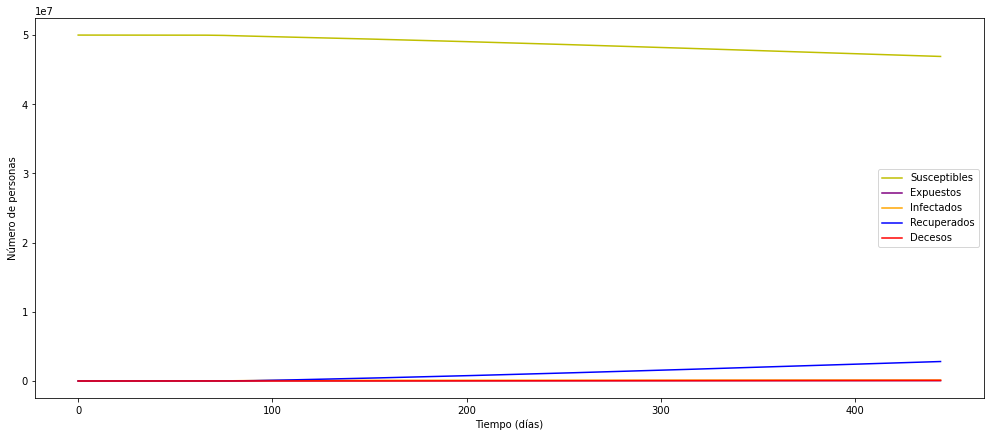

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(t, S, 'y', label = "Susceptibles")
plt.plot(t, E, color = 'purple', label = "Expuestos")
plt.plot(t, I, color = 'orange', label = "Infectados")
plt.plot(t, R, 'b', label = "Recuperados")
plt.plot(t, D, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

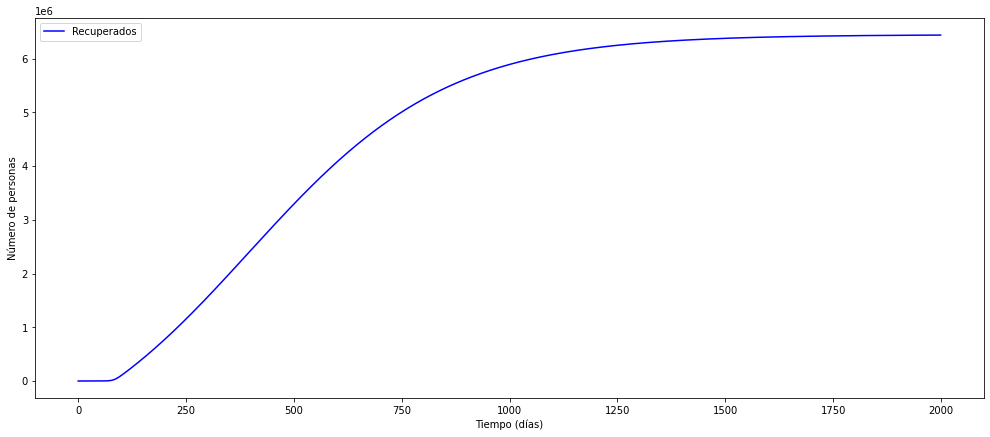

In [ ]:
# solucion
t2 = np.arange(0,2000,1)
solucion = odeint(nuevas_ecuaciones_SEIRD, y0, t2, args = (beta, gamma, alpha, rho, delta))
S2,E2,I2,R2,D2 = solucion.T

# Gráfica 1000 días:
plt.figure(figsize=(17,7))
#plt.plot(t2, S2, 'y', label = "Susceptibles")
#plt.plot(t2, E2, 'g', label = "Expuestos")
#plt.plot(t2, I2, color = 'orange', label = "Infectados")
plt.plot(t2, R2, 'b', label = "Recuperados")
#plt.plot(t2, D2, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

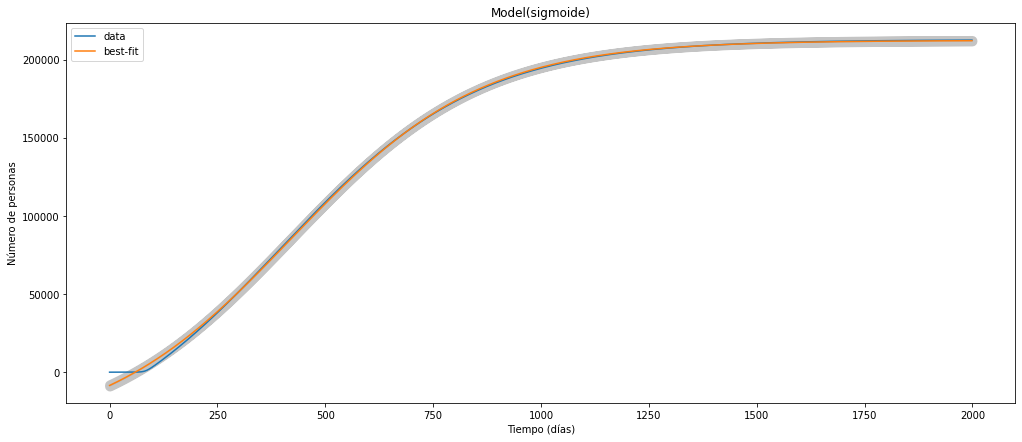

El modelo tiene un r^2 de: 0.9997251718407892


In [ ]:
# Modelo
modelo_ajuste_muertes = lmfit.Model(sigmoide)

# Parámetros iniciales
modelo_ajuste_muertes.set_param_hint("a", value = 2000.0, vary = True)
modelo_ajuste_muertes.set_param_hint("b", value = 100.0, vary = True)
modelo_ajuste_muertes.set_param_hint("c", value = 100.0, vary = True)
modelo_ajuste_muertes.set_param_hint("d", value = 600.0, vary = True)
parametros_muerte = modelo_ajuste_muertes.make_params()

# Resultado
resultado_ = modelo_ajuste_muertes.fit(D2,parametros_muerte, method = metodo,t=t2)

# Plot resultados
plt.figure(figsize=(17,7))
dely4 = resultado_.eval_uncertainty(sigma=3)
resultado_.plot_fit(datafmt="-")

# Graficando incertidumbre a 3-sigma.
plt.fill_between(t2, resultado_.best_fit-dely4, resultado_.best_fit + dely4, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 10, alpha = 0.7)
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_ajuste_muertes = 1 - resultado_.residual.var()/np.var(D2)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_ajuste_muertes))

# Se imprimen datos generales de los resultados
resultado_

In [ ]:
#Intervalo de confianza de los parámetros
print(resultado_.ci_report())

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:-140.18251 -94.92469 -45.31685212560.78662 +45.33764 +95.02378+140.24106
 b:-1033.27342-687.48933-343.43089-254028.13992+342.13657+680.74931+1021.32469
 c:  -2.05964  -1.37131  -0.68453 421.03217  +0.68236  +1.35959  +2.03697
 d:  -1.23174  -0.82102  -0.40799-221.24847  +0.40883  +0.81643  +1.22158


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_ajuste_muertes/3)/((1-Rcuadrado_ajuste_muertes)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

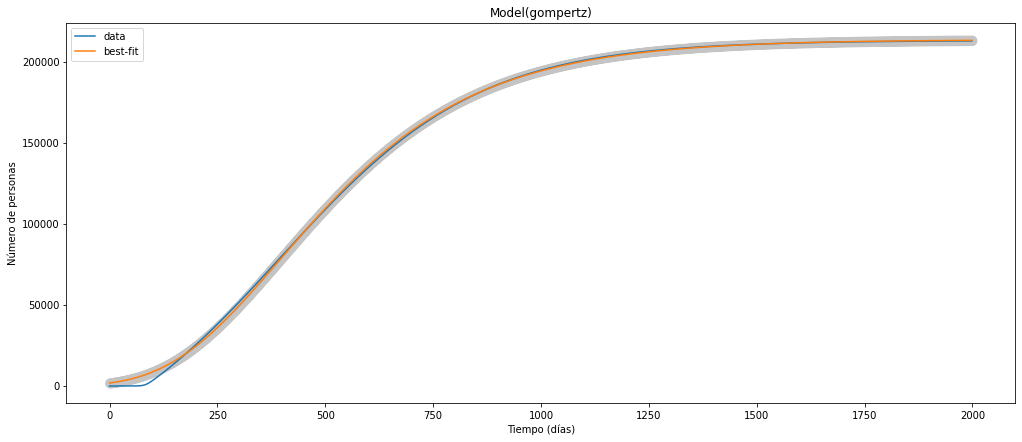

El modelo tiene un r^2 de: 0.9996429641067748


In [ ]:
# Modelo
modelo_ajuste_muertes = lmfit.Model(gompertz)

# Parámetros iniciales
modelo_ajuste_muertes.set_param_hint("a", value = 200000.0, vary = True)
modelo_ajuste_muertes.set_param_hint("b", value = 100.0, vary = True)
modelo_ajuste_muertes.set_param_hint("c", value = 0.01, vary = True)
parametros_muerte = modelo_ajuste_muertes.make_params()

# Resultado
resultado_ = modelo_ajuste_muertes.fit(D2,parametros_muerte, method = metodo,t=t2)

# Plot Resultados
plt.figure(figsize=(17,7))
dely4 = resultado_.eval_uncertainty(sigma=3)
resultado_.plot_fit(datafmt="-")

# Graficando incertidumbre a 3-sigma.
plt.fill_between(t2, resultado_.best_fit-dely4, resultado_.best_fit + dely4, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 10, alpha = 0.7)
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_ajuste_muertes = 1 - resultado_.residual.var()/np.var(D2)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_ajuste_muertes))

# Se imprimen datos generales de los resultados
resultado_

In [ ]:
# Intervalo de confianza para los parámetros
print(resultado_.ci_report())

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:-160.05248-106.87202 -54.77597212768.60846 +54.77828+107.03986+160.05248
 b:  -0.03001  -0.02000  -0.01003   4.73087  +0.01007  +0.02016  +0.03027
 c:  -0.00001  -0.00001  -0.00000   0.00392  +0.00000  +0.00001  +0.00001


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_ajuste_muertes/3)/((1-Rcuadrado_ajuste_muertes)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

### Ajuste contagios
Para este caso utilizamos funciones con pico y crecimiento suavizado, es decir la ADS y la logística con potencia.

In [ ]:
# Extraemos parámetros del mejor ajuste a curva de recuperados
valores = list(map(lambda x: x[:][1],list(resultado_contagios.best_values.items())))

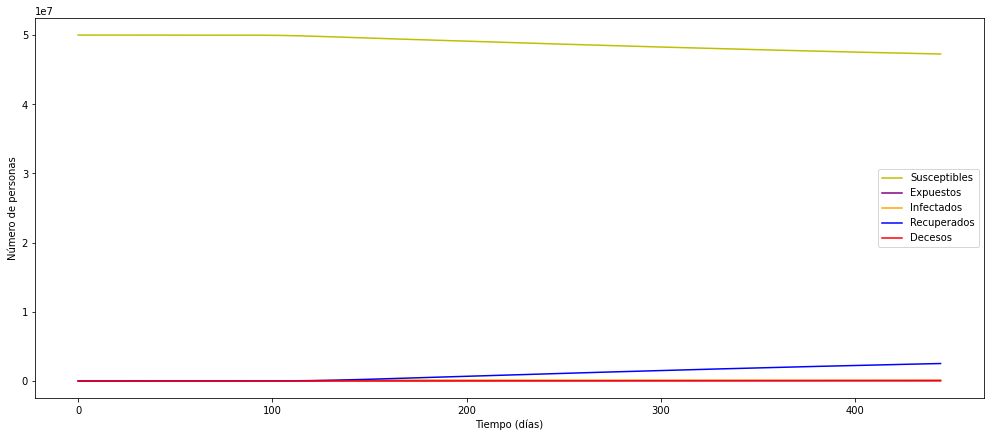

In [ ]:
solucion = odeint(nuevas_ecuaciones_SEIRD, y0, t, args = (beta, gamma, alpha, rho, delta))
S,E,I,R,D = solucion.T
plt.figure(figsize=(17,7))
plt.plot(t, S, 'y', label = "Susceptibles")
plt.plot(t, E, color = 'purple', label = "Expuestos")
plt.plot(t, I, color = 'orange', label = "Infectados")
plt.plot(t, R, 'b', label = "Recuperados")
plt.plot(t, D, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

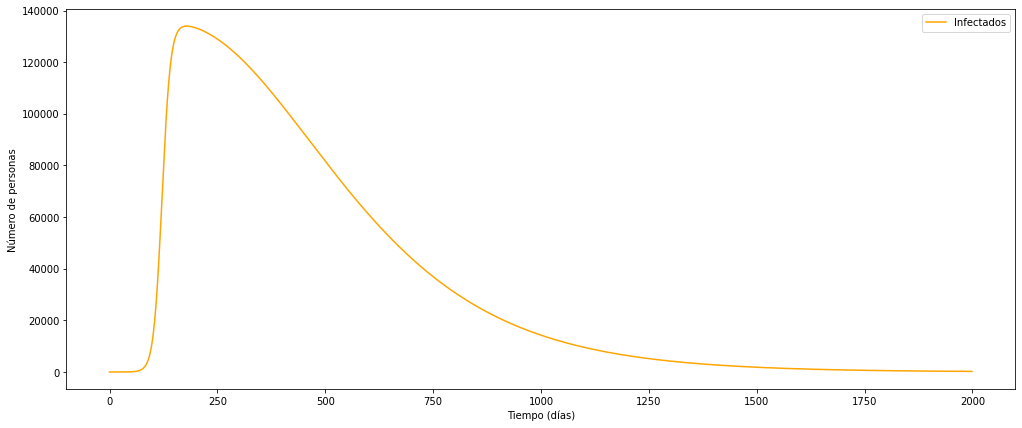

In [ ]:
# solución
t2 = np.arange(0,2000,1)
solucion = odeint(nuevas_ecuaciones_SEIRD, y0, t2, args = (beta, gamma, alpha, rho, delta))
S2,E2,I2,R2,D2 = solucion.T

# Gráfica 1000 días:
plt.figure(figsize=(17,7))
#plt.plot(t2, S2, 'y', label = "Susceptibles")
#plt.plot(t2, E2, 'g', label = "Expuestos")
plt.plot(t2, I2, color = 'orange', label = "Infectados")
#plt.plot(t2, R2, 'b', label = "Recuperados")
#plt.plot(t2, D2, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

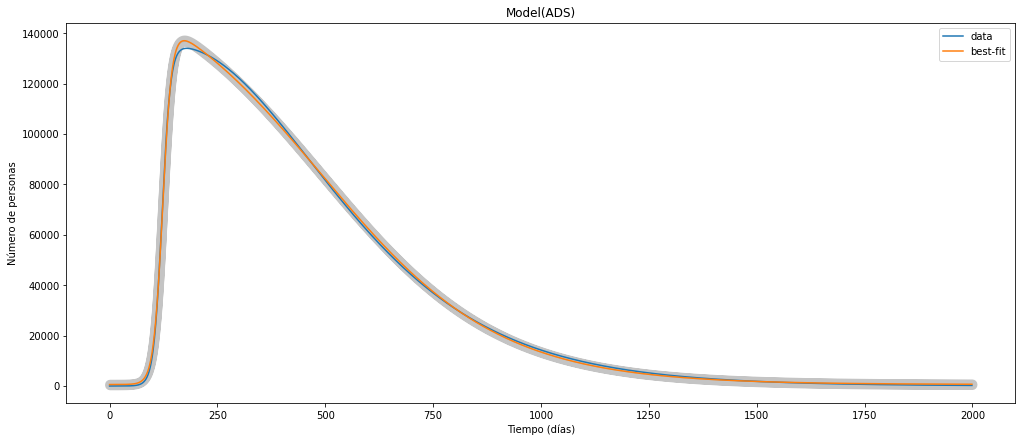

El modelo tiene un r^2 de: 0.999598903475255


In [ ]:
# Modelo
modelo_ajuste_contagios = lmfit.Model(ADS)

# Parámetros iniciales
modelo_ajuste_contagios.set_param_hint("a", value = 100.0, vary = True)
modelo_ajuste_contagios.set_param_hint("b", value = 0.0, vary = True)
modelo_ajuste_contagios.set_param_hint("c", value = 300.0, vary = True)
modelo_ajuste_contagios.set_param_hint("d", value = 300.0, vary = True)
modelo_ajuste_contagios.set_param_hint("e", value = 10.0, vary = True)
modelo_ajuste_contagios.set_param_hint("f", value = 100.0, vary = True)
parametros_contagios = modelo_ajuste_contagios.make_params()

# Resultado
resultado_c = modelo_ajuste_contagios.fit(I2,parametros_contagios, method = metodo,t=t2)

# Plot resultados
plt.figure(figsize=(17,7))
dely5 = resultado_c.eval_uncertainty(sigma=3)
resultado_c.plot_fit(datafmt="-")

# Graficando incertidumbre 3-sigma
plt.fill_between(t2, resultado_c.best_fit-dely5, resultado_c.best_fit + dely5, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 10, alpha = 0.7)
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_ajuste_contagios = 1 - resultado_c.residual.var()/np.var(I2)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_ajuste_contagios))

# Se imprimen datos generales de los resultados
resultado_c

In [ ]:
# Intervalo de confianza para los parámetros
print(resultado_c.ci_report())

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:-103.00559 -68.59445 -34.27014 589.53202 +34.24065 +68.46686+102.71424
 b:-1020.87151-683.72066-343.08183167057.47658+344.30665+694.15858+1046.00263
 c:  -1.40632  -0.93602  -0.46412 306.87318  +0.46306  +0.92199  +1.38070
 d:  -2.93595  -1.95037  -0.96769 366.88915  +0.96555  +1.92510  +2.87985
 e:  -0.14525  -0.09699  -0.04863  10.59021  +0.04879  +0.09751  +0.14635
 f:  -1.48621  -0.99190  -0.49469 205.41325  +0.49635  +0.99858  +1.50233


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_ajuste_contagios/3)/((1-Rcuadrado_ajuste_contagios)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

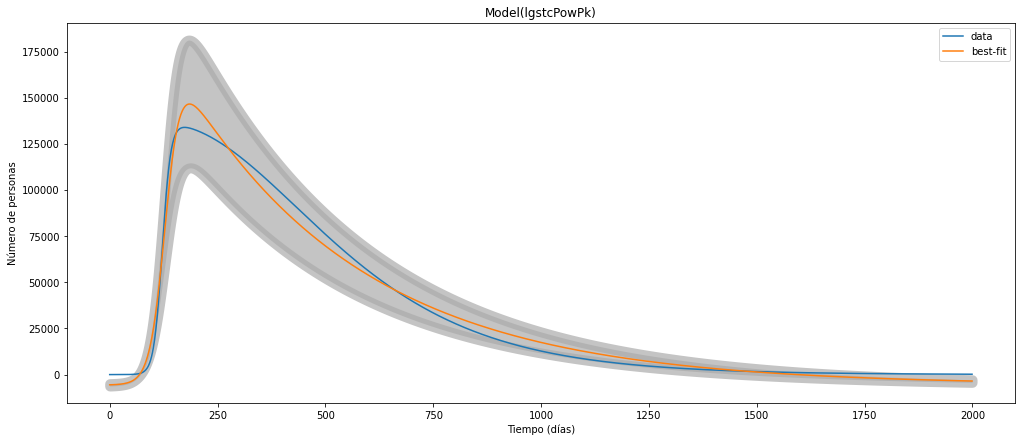

El modelo tiene un r^2 de: 0.9890774715959455


In [ ]:
# Modelo
modelo_ajuste_contagios = lmfit.Model(lgstcPowPk)

# Parámetros iniciales
modelo_ajuste_contagios.set_param_hint("a", value = 0.0, vary = True)
modelo_ajuste_contagios.set_param_hint("b", value = 10.0, vary = True)
modelo_ajuste_contagios.set_param_hint("c", value = 100.0, vary = True)
modelo_ajuste_contagios.set_param_hint("d", value = 100.0, vary = True)
modelo_ajuste_contagios.set_param_hint("e", value = 10.0, vary = True)
parametros_contagios = modelo_ajuste_contagios.make_params()

# Resultado
resultado_c = modelo_ajuste_contagios.fit(I2,parametros_contagios, method = metodo,t=t2)

# Plot resultados
plt.figure(figsize=(17,7))
dely5 = resultado_c.eval_uncertainty(sigma=3)
resultado_c.plot_fit(datafmt="-")

# Graficando incertidumbre de 3-sigma
plt.fill_between(t2, resultado_c.best_fit-dely5, resultado_c.best_fit + dely5, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 10, alpha = 0.7)
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_ajuste_contagios = 1 - resultado_c.residual.var()/np.var(I2)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_ajuste_contagios))

# Se imprimen los datos generales del modelo
resultado_c

In [ ]:
# Intervalo de confianza para los parámetros.
print(resultado_c.ci_report())


      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:-103.00559 -68.59445 -34.27014 589.53202 +34.24065 +68.46686+102.71424
 b:-1020.87151-683.72066-343.08183167057.47658+344.30665+694.15858+1046.00263
 c:  -1.40632  -0.93602  -0.46412 306.87318  +0.46306  +0.92199  +1.38070
 d:  -2.93595  -1.95037  -0.96769 366.88915  +0.96555  +1.92510  +2.87985
 e:  -0.14525  -0.09699  -0.04863  10.59021  +0.04879  +0.09751  +0.14635
 f:  -1.48621  -0.99190  -0.49469 205.41325  +0.49635  +0.99858  +1.50233


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_ajuste_contagios/3)/((1-Rcuadrado_ajuste_contagios)/448)
p = 1 - f.cdf(F, 3, 448)
p

1.1102230246251565e-16

### Ajuste recuperados 
Para este caso utilizamos funciones tipo "S", es decir la sigmoide y la Gompertz

In [ ]:
# Extraemos parámetros del mejor ajuste a curva de recuperados
valores = list(map(lambda x: x[:][1],list(resultado_recuperados.best_values.items())))

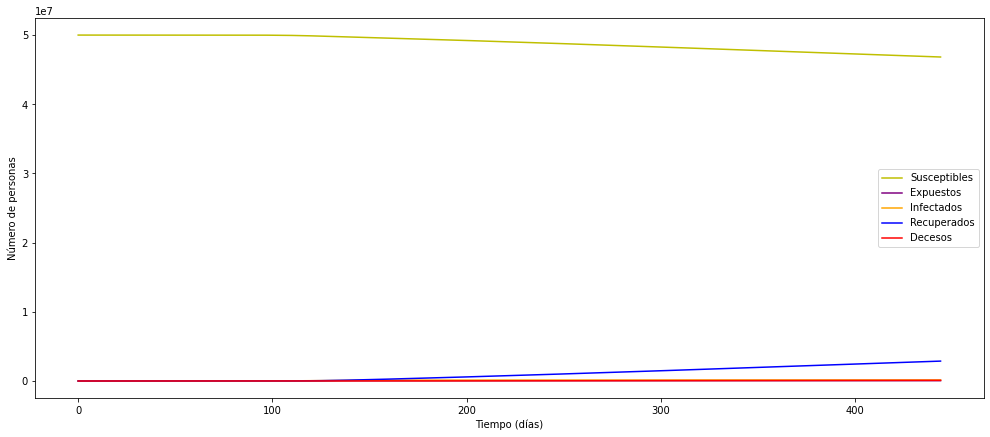

In [ ]:
solucion = odeint(nuevas_ecuaciones_SEIRD, y0, t, args = (beta, gamma, alpha, rho, delta))
S,E,I,R,D = solucion.T
plt.figure(figsize=(17,7))
plt.plot(t, S, 'y', label = "Susceptibles")
plt.plot(t, E, color = 'purple', label = "Expuestos")
plt.plot(t, I, color = 'orange', label = "Infectados")
plt.plot(t, R, 'b', label = "Recuperados")
plt.plot(t, D, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

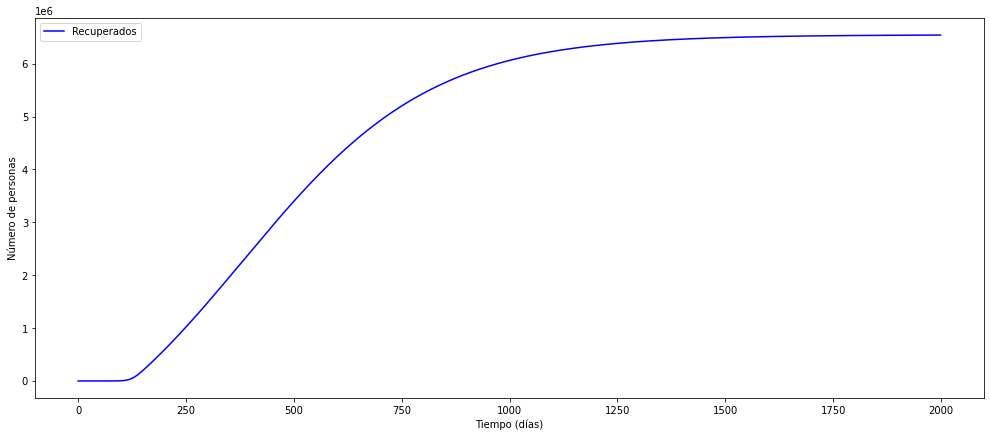

In [ ]:
# solucion
t2 = np.arange(0,2000,1)
solucion = odeint(nuevas_ecuaciones_SEIRD, y0, t2, args = (beta, gamma, alpha, rho, delta))
S2,E2,I2,R2,D2 = solucion.T

# Gráfica 1000 días:
plt.figure(figsize=(17,7))
#plt.plot(t2, S2, 'y', label = "Susceptibles")
#plt.plot(t2, E2, 'g', label = "Expuestos")
#plt.plot(t2, I2, color = 'orange', label = "Infectados")
plt.plot(t2, R2, 'b', label = "Recuperados")
#plt.plot(t2, D2, 'r', label = "Decesos")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.legend()
plt.show()

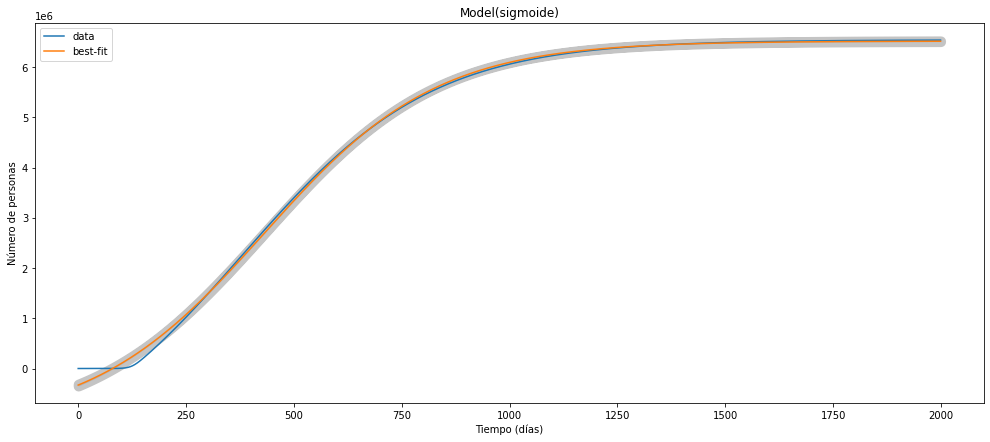

El modelo tiene un r^2 de: 0.9992522221502304


In [ ]:
# Modelo
modelo_ajuste_recuperados = lmfit.Model(sigmoide)

# Parámetros iniciales
modelo_ajuste_recuperados.set_param_hint("a", value = 0.0, vary = True)
modelo_ajuste_recuperados.set_param_hint("b", value = 100.0, vary = True)
modelo_ajuste_recuperados.set_param_hint("c", value = 100.0, vary = True)
modelo_ajuste_recuperados.set_param_hint("d", value = 600.0, vary = True)
parametros_recuperados = modelo_ajuste_recuperados.make_params()

# Resultado
resultado_r = modelo_ajuste_recuperados.fit(R2,parametros_recuperados, method = metodo,t=t2)

# Plot resultado
plt.figure(figsize=(17,7))
dely5 = resultado_r.eval_uncertainty(sigma=3)
resultado_r.plot_fit(datafmt="-")

# Graficando incertidumbre de 3-sigma
plt.fill_between(t2, resultado_r.best_fit-dely5, resultado_r.best_fit + dely5, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 10, alpha = 0.7)
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_ajuste_recuperados = 1 - resultado_r.residual.var()/np.var(R2)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_ajuste_recuperados))

# Se imprimen datos generales del modelo
resultado_r

In [ ]:
# Intervalo de confianza de los parámetros
print(resultado_r.ci_report())

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:-7016.51183-4620.85928-2296.388696520444.52872+2298.48524+4631.09279+7043.30724
 b:-44846.25466-29781.64616-14846.39996-7645411.61857+14754.11558+29369.71135+44039.59352
 c:  -2.79359  -1.85815  -0.92695 431.66345  +0.92208  +1.83548  +2.75283
 d:  -1.79436  -1.19370  -0.59287-200.36155  +0.59306  +1.18374  +1.77301


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_ajuste_recuperados/3)/((1-Rcuadrado_ajuste_recuperados)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16

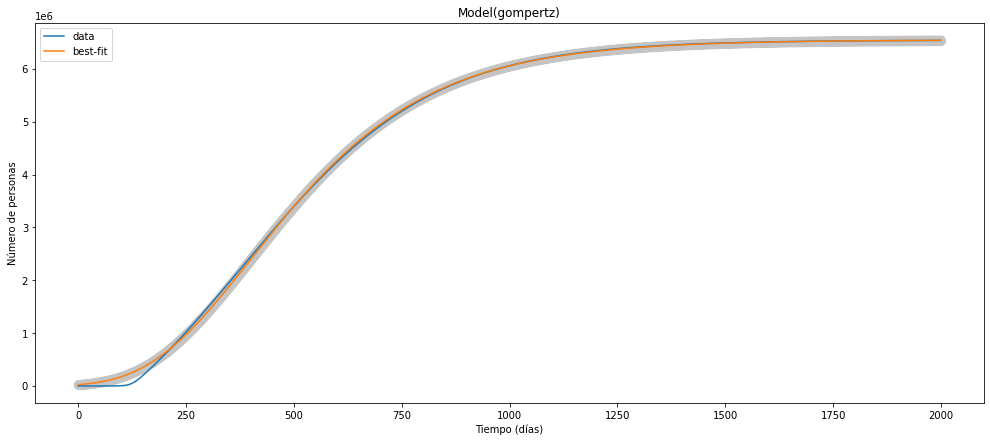

El modelo tiene un r^2 de: 0.9995936990992708


In [ ]:
# Modelo
modelo_ajuste_recuperados = lmfit.Model(gompertz)

# Parámetros iniciales
modelo_ajuste_recuperados.set_param_hint("a", value = 2000000.0, vary = True)
modelo_ajuste_recuperados.set_param_hint("b", value = 2.0, vary = True)
modelo_ajuste_recuperados.set_param_hint("c", value = 0.001, vary = True)
parametros_recuperados = modelo_ajuste_recuperados.make_params()

# Resultado
resultado_r = modelo_ajuste_recuperados.fit(R2,parametros_recuperados, method = metodo,t=t2)

# Plot resultados
plt.figure(figsize=(17,7))
dely5 = resultado_r.eval_uncertainty(sigma=3)
resultado_r.plot_fit(datafmt="-")

#Graficando incertidumbre de 3-sigma.
plt.fill_between(t2, resultado_r.best_fit-dely5, resultado_r.best_fit + dely5, color="#ABABAB",
                 label='banda de confianza de 3$\sigma$', linewidth = 10, alpha = 0.7)
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de personas")
plt.show()

# Coeficiente de determinación o R^2
Rcuadrado_ajuste_recuperados = 1 - resultado_r.residual.var()/np.var(R2)
print("El modelo tiene un r^2 de: " + str(Rcuadrado_ajuste_recuperados))

# Se imprimen los datos generales del modelo
resultado_r

In [ ]:
# Intervalo de confianza de los parámetros
print(resultado_r.ci_report())

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:-5126.98647-3436.09548-1754.749896548918.35061+1642.73675+3390.51561+5016.75628
 b:  -0.04240  -0.02827  -0.01418   5.53071  +0.01425  +0.02853  +0.04297
 c:  -0.00002  -0.00001  -0.00001   0.00427  +0.00001  +0.00001  +0.00002


In [ ]:
# Realizando el test de significancia estadística del modelo
F = (Rcuadrado_ajuste_recuperados/3)/((1-Rcuadrado_ajuste_recuperados)/442)
p = 1 - f.cdf(F, 3, 442)
p

1.1102230246251565e-16